# Group 3: Modelling and Optimization

### Purpose of notebook
The goal of this notebook is to evaluate various models and determine the best one for our data, then fine-tune its parameters for optimal performance.

### Table of Contents
1. Loading CSV file
2. Modelling
3. Hyperparameter Tuning 
4. Conclusion

--------------------
#### Import Modules

In [4]:
import pandas as pd
import numpy as np

import joblib
import dask.dataframe as dd
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

import mlflow
from dask import config

import warnings
import time
warnings.filterwarnings("ignore")

In [ ]:
#!pip install imblearn

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

steps = [
    ("LOF", LocalOutlierFactor(contamination=0.05)),
    ("Oversampling", RandomOverSampler(random_state=11)),
    ("Standardisation", StandardScaler()),
    ('model')
]

steps[-1] = ("model", DecisionTreeClassifier())

d_tree_clf = Pipeline(steps=steps)
d_tree_clf.fit(X_train, y_train)

### Read Dataset using Dask Module

In [5]:
# Instantiate Dask Client
client = Client()
client.amm.start()

In [6]:
config.set({'interface': 'lo'})

In [7]:
# Read CSV file using Dask Pandas
ddf = dd.read_csv("TaxiDatasetAgg.csv")

In [8]:
# Shape of Dataframe
ddf_comp = ddf.compute()

In [9]:
ddf_comp.shape

(19990, 53)

In [10]:
# Print top 5
ddf_comp.head()

,acceleration_x_mean,acceleration_x_max,acceleration_x_min,acceleration_x_std,acceleration_y_mean,acceleration_y_max,acceleration_y_min,acceleration_y_std,acceleration_z_mean,acceleration_z_max,...,roll_std,turning_force_mean,turning_force_max,turning_force_min,turning_force_std,acceleration_mean,acceleration_max,acceleration_min,acceleration_std,label
0,-0.695480,4.782614,-4.692294,0.931499,-9.412594,9.963742,-12.190784,1.843825,-1.502891,3.863739,...,47.916011,-248829.625010,1120258.2,-1236779.5,425243.970106,0.012712,0.137985,0.0,0.021438,0
1,-0.495516,3.387767,-5.352994,0.801738,9.511599,11.435962,-0.050786,0.710092,-2.171415,2.192435,...,19.851665,285205.060068,1273353.1,-1161197.1,344555.457697,0.032536,1.839744,0.0,0.138877,1
2,0.273682,1.956122,-1.565856,0.764038,9.641519,11.248303,-0.918849,1.241399,0.069412,1.755003,...,41.745082,101651.138084,1374232.5,-829088.4,348493.922292,0.056233,0.514143,0.0,0.092621,1
3,-0.360124,4.517638,-2.866458,0.613654,-9.222140,10.763396,-12.916333,1.794614,-2.612529,2.752219,...,43.179891,-194387.143445,1375305.5,-1277482.1,303380.890713,0.036966,5.170000,0.0,0.258846,1
4,0.550104,4.654470,-2.013585,0.784925,9.407493,13.249917,-8.235179,1.392413,2.290829,6.263423,...,36.655893,269459.647881,1427426.4,-973504.2,359611.049924,0.064067,9.454126,0.0,0.521633,0


In [11]:
ddf_comp.columns

Index(['acceleration_x_mean', 'acceleration_x_max', 'acceleration_x_min',
       'acceleration_x_std', 'acceleration_y_mean', 'acceleration_y_max',
       'acceleration_y_min', 'acceleration_y_std', 'acceleration_z_mean',
       'acceleration_z_max', 'acceleration_z_min', 'acceleration_z_std',
       'gyro_x_mean', 'gyro_x_max', 'gyro_x_min', 'gyro_x_std', 'gyro_y_mean',
       'gyro_y_max', 'gyro_y_min', 'gyro_y_std', 'gyro_z_mean', 'gyro_z_max',
       'gyro_z_min', 'gyro_z_std', 'second_mean', 'second_max', 'second_min',
       'second_std', 'speed (km/h)_mean', 'speed (km/h)_max',
       'speed (km/h)_min', 'speed (km/h)_std', 'yaw_mean', 'yaw_max',
       'yaw_min', 'yaw_std', 'pitch_mean', 'pitch_max', 'pitch_min',
       'pitch_std', 'roll_mean', 'roll_max', 'roll_min', 'roll_std',
       'turning_force_mean', 'turning_force_max', 'turning_force_min',
       'turning_force_std', 'acceleration_mean', 'acceleration_max',
       'acceleration_min', 'acceleration_std', 'label'],
   

In [5]:
# Split Data
X = ddf.drop('label', axis=1)
y = ddf['label']

In [6]:
# Dask_ml Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train: {X_train.compute().shape}\ny_train: {y_train.compute().shape}\nX_test: {X_test.compute().shape}\ny_test: {y_test.compute().shape}')

### Plot Graphs to evaluate model
- Confusion Matrix
- AUC-ROC curve
- Learning Curve

In [7]:
# Evaluate Classifier 
def evaluate_classifier(name, model):
    print(f'\n\n**********************{name}**********************')
    # Train Model
    #with joblib.parallel_backend('dask'):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    auc = roc_auc_score(y_test, y_pred_proba)
    
    fig = plt.figure(figsize=(15,10))
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    ax1.plot(fpr, tpr, label="AUC= " + str(auc))
    ax1.set_title(f'{name} - ROC Curve', fontsize=18)
    ax1.set_ylabel("True Positive Rate", fontsize=14)
    ax1.set_xlabel("False Positive Rate", fontsize=14)
    ax1.legend(loc=4, fontsize=14)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Dangerous", "Dangerous"])
    disp = disp.plot(ax=ax2, cmap='Blues')
    disp.ax_.set_title(name, fontsize=20)
    disp.ax_.set_xlabel('True Label', fontsize=14)
    disp.ax_.set_ylabel('Predicted Label', fontsize=14)

    train_sizes, train_scores, test_scores = learning_curve(model, X_train.to_dask_array(lengths=True), y_train.to_dask_array(lengths=True), cv=10, train_sizes=np.linspace(0.1, 1.0, 10),n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

## Metrics

In [ ]:
metric = ['f1', 'accuracy', 'precision', 'recall']    # Scoring Metrics

# Models

In [24]:
models = {
    "Decision Tree Classifier": DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Gausian Naive Bayes': GaussianNB(),
    'Support Vector Classifier': SVC(probability=True),
}


## Cross Validation

In [ ]:
df_stats = {}    # Store model results

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s finished




**********************Decision Tree Classifier**********************


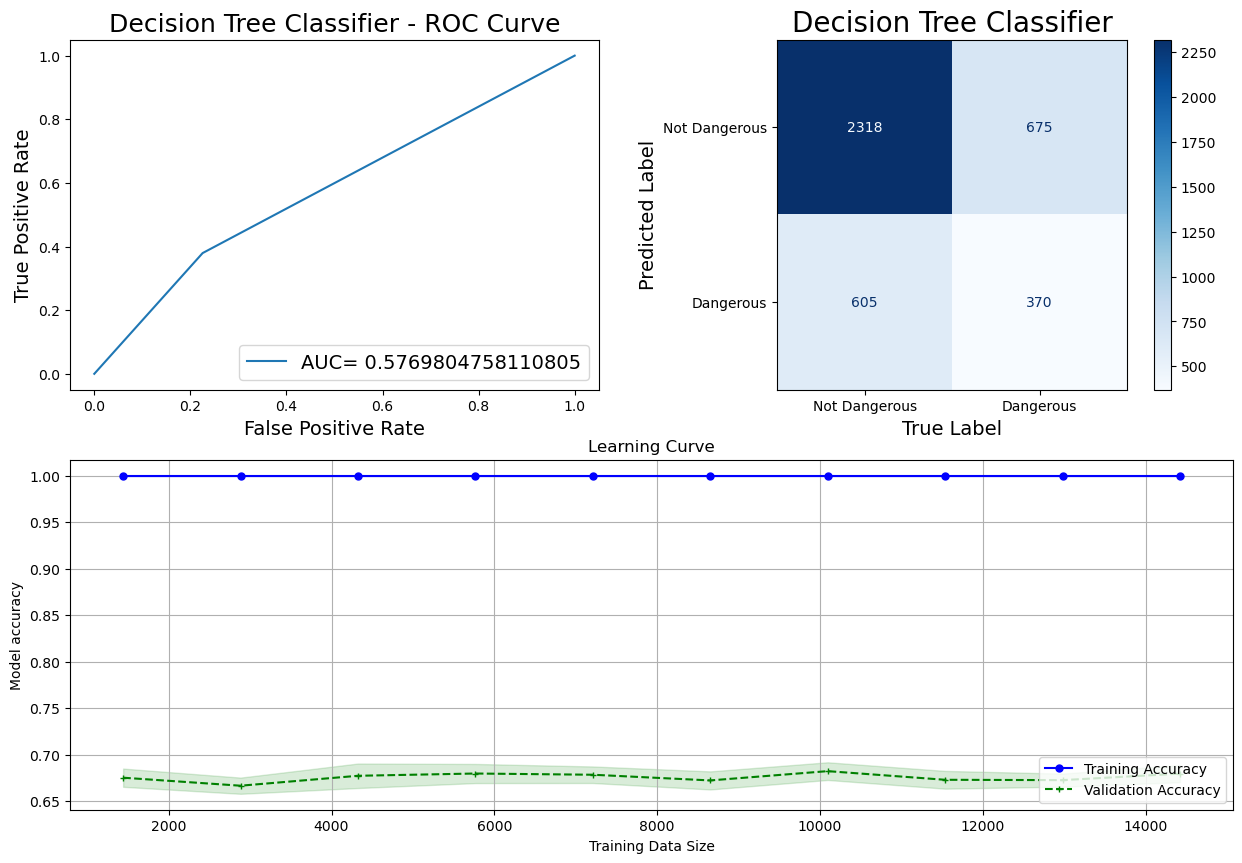

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.0s finished




**********************Random Forest Classifier**********************


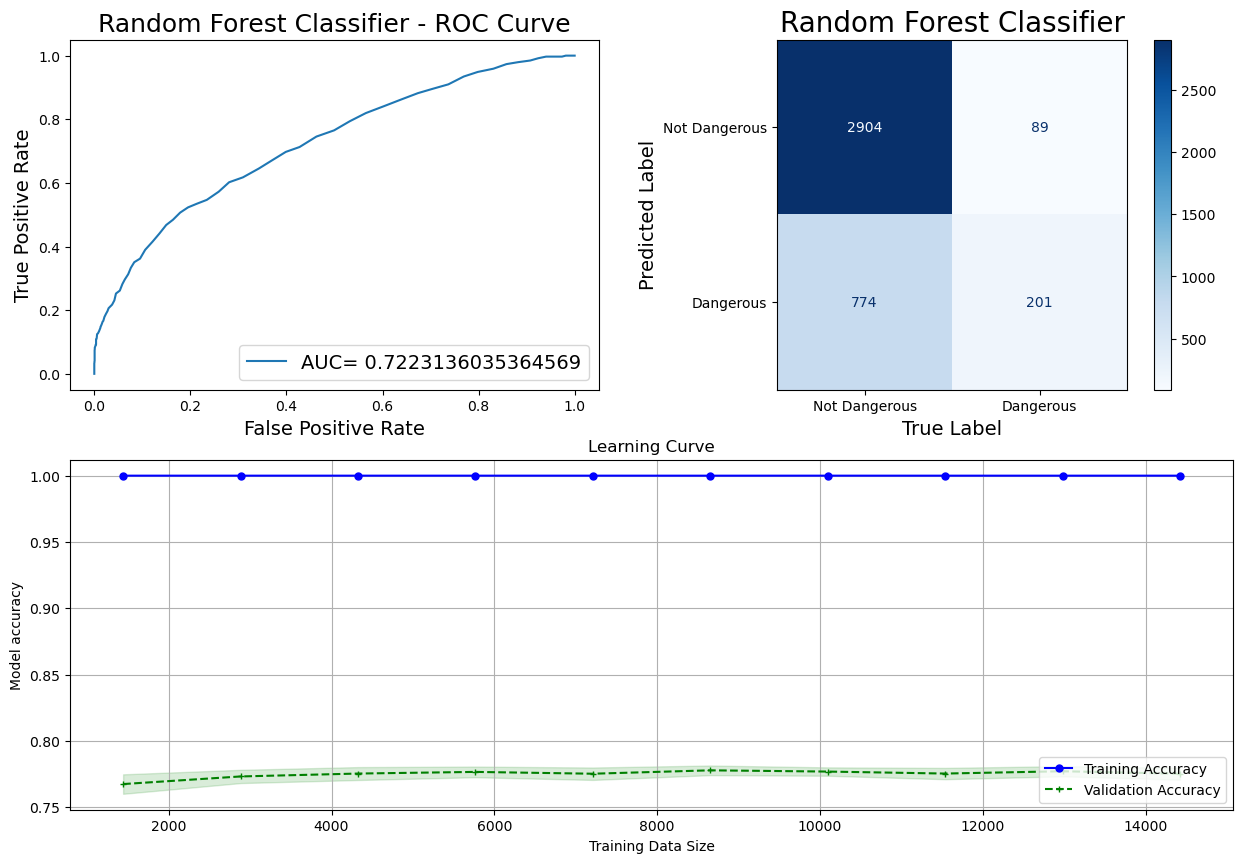

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.1s finished




**********************Logistic Regression**********************


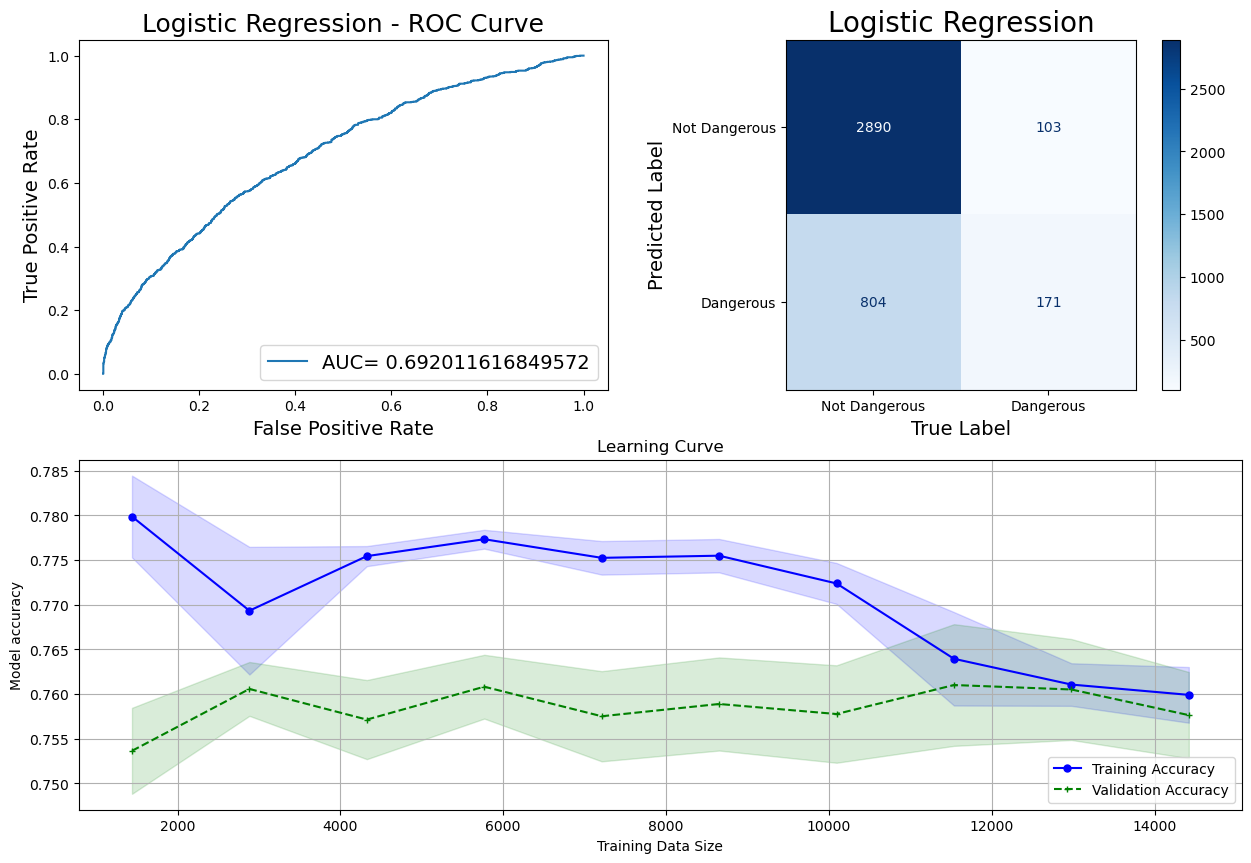

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s finished




**********************KNN**********************


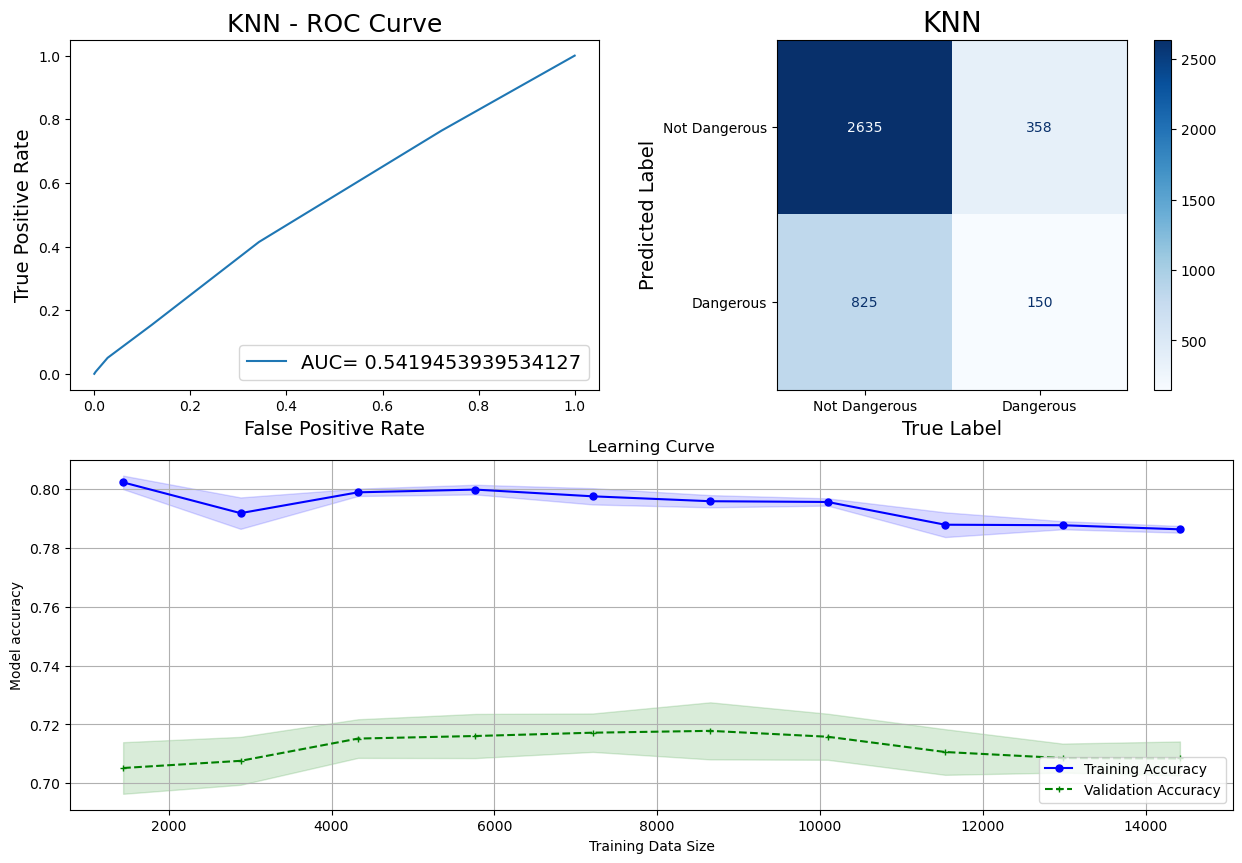

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s finished




**********************Gausian Naive Bayes**********************


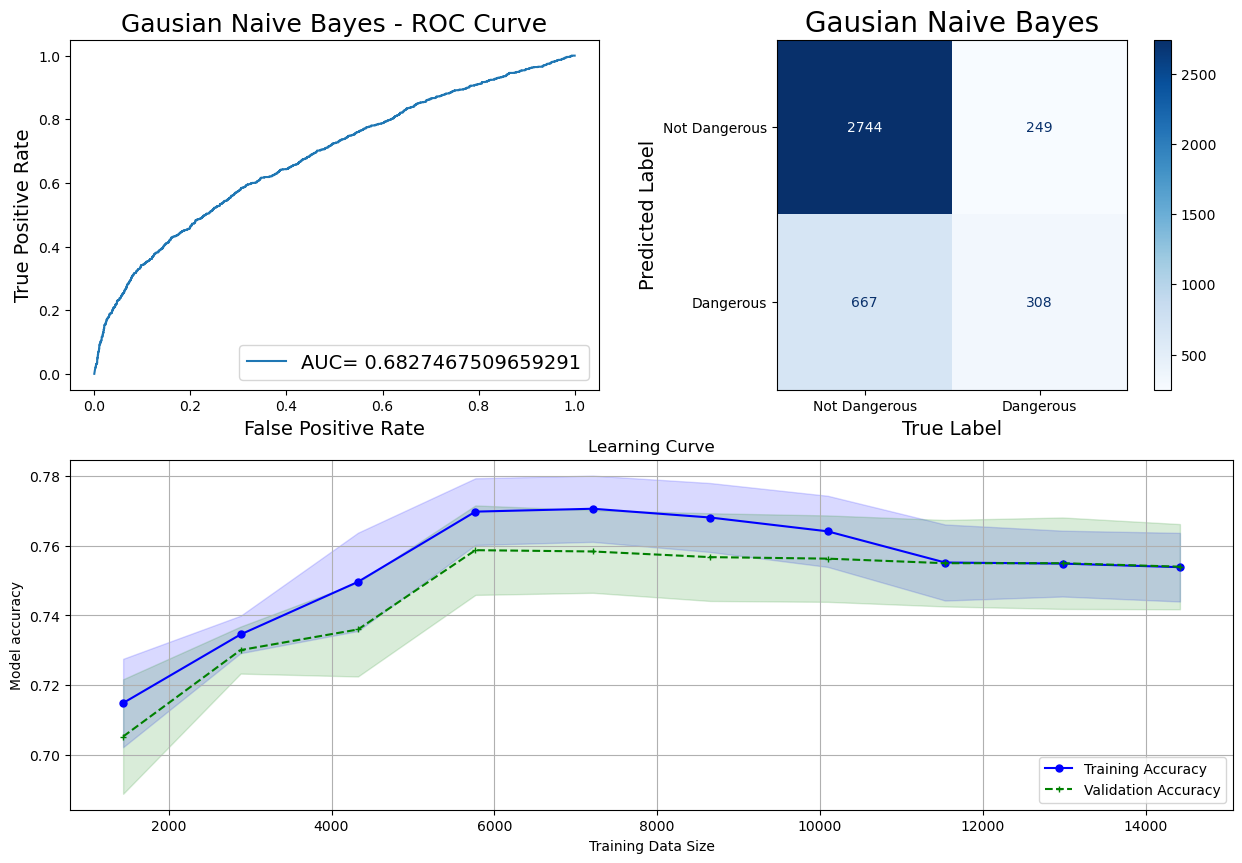

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished




**********************Support Vector Classifier**********************


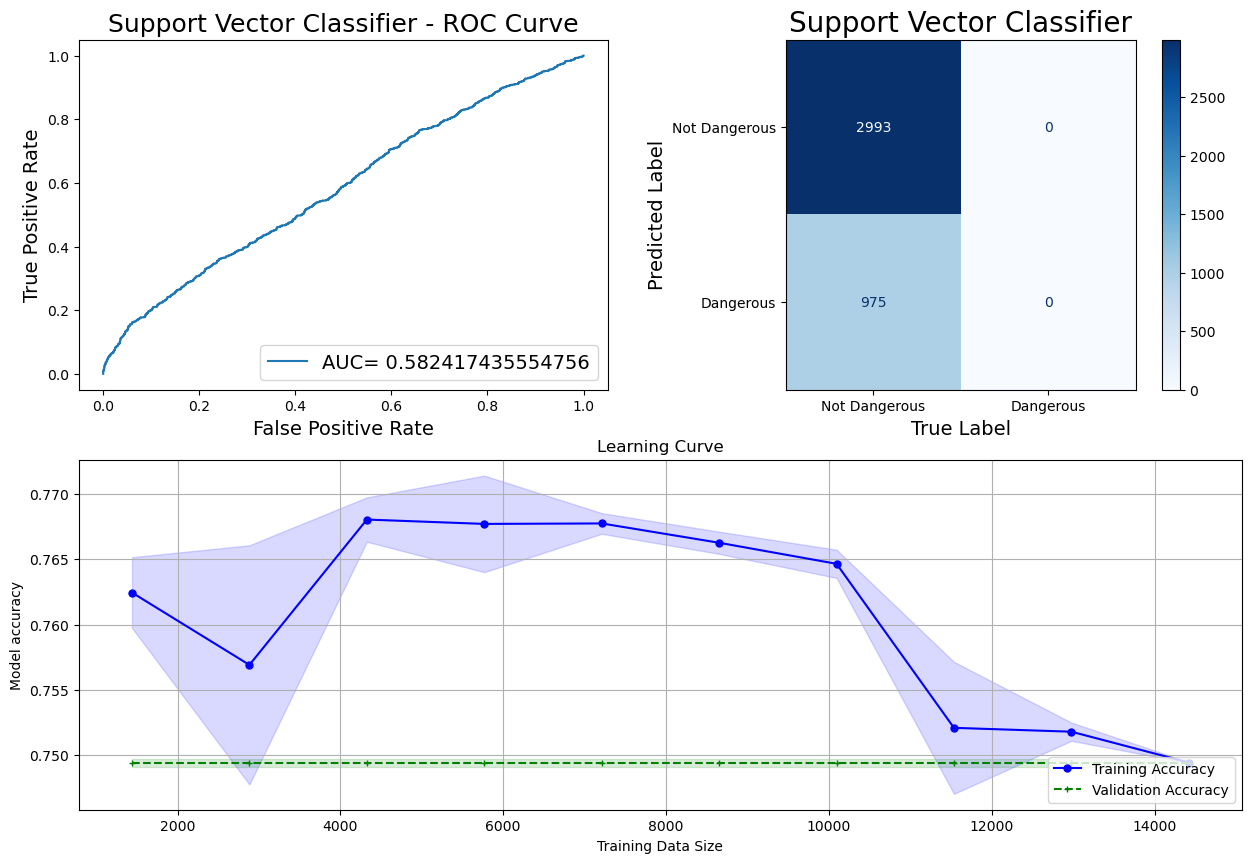

In [25]:
for name, model in models.items():
    with joblib.parallel_backend('dask'):
        with mlflow.start_run(run_name=name):
            cv_results = cross_validate(model, X_train.to_dask_array(lengths=True),
                                        y_train.to_dask_array(lengths=True), return_train_score=True,
                                        cv=5, scoring=metric, verbose=1, n_jobs=1)

            cv_results_avg = {f'mean_{i}': np.mean(v) for i,v in cv_results.items()}   # Calculate mean of Kfolds
            
            # log model into mlflow
            mlflow.sklearn.log_model(
            model, 
            name, 
            serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE
            ) 

            # Log metric into mlflow
            for i in cv_results_avg.keys():
                mlflow.log_metric(i, cv_results_avg[i])
            
            df_stats[name] = cv_results_avg   # Store Results to dictionary
            evaluate_classifier(name, model)    # Plot graph to evaluate model
        

## Gradient Boosting Algorithms

In [38]:
models = {
    'Extreme Gradient Boosting': XGBClassifier(n_jobs=-1),
    'Light GBM': LGBMClassifier()
}

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.3s finished




**********************Extreme Gradient Boosting**********************


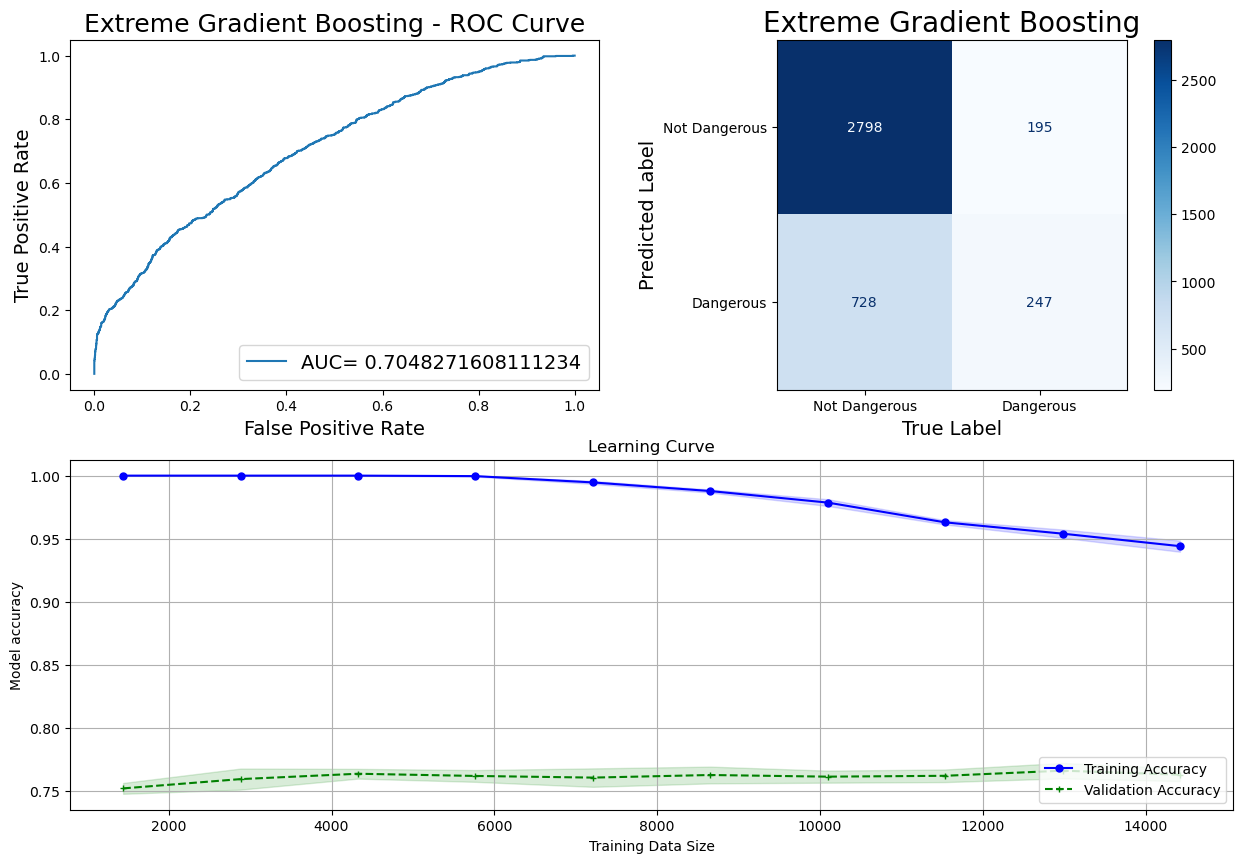

[Parallel(n_jobs=1)]: Using backend DaskDistributedBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.4s finished




**********************Light GBM**********************


2023-01-23 08:48:06,729 - distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-f92483065d263b23a50f80443bc0f8e7', 0)": []} state: ['waiting'] workers: []
NoneType: None
2023-01-23 08:48:06,730 - distributed.scheduler - ERROR - Shut down workers that don't have promised key: [], ('getitem-f92483065d263b23a50f80443bc0f8e7', 0)
NoneType: None
2023-01-23 08:48:06,792 - distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-f92483065d263b23a50f80443bc0f8e7', 0)": []} state: ['waiting'] workers: []
NoneType: None
2023-01-23 08:48:06,793 - distributed.scheduler - ERROR - Shut down workers that don't have promised key: [], ('getitem-f92483065d263b23a50f80443bc0f8e7', 0)
NoneType: None


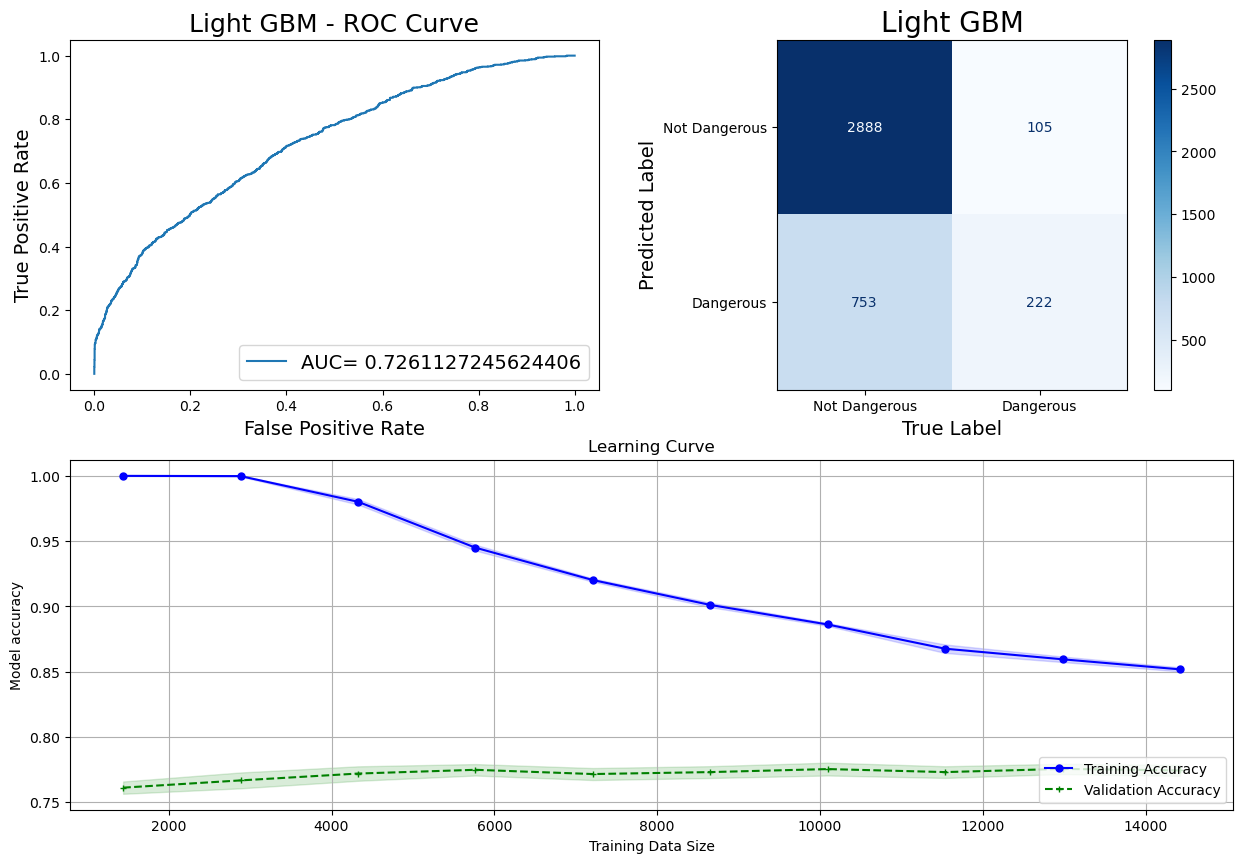

In [42]:
for name, model in models.items():
    with joblib.parallel_backend('dask'):
        with mlflow.start_run(run_name=name):
            cv_results = cross_validate(model, X_train.to_dask_array(lengths=True),
                                        y_train.to_dask_array(lengths=True), return_train_score=True,
                                        cv=5, scoring=metric, verbose=1, n_jobs=1)
        
            cv_results_avg = {f'mean_{i}': np.mean(v) for i,v in cv_results.items()}   # Calculate mean of Kfolds
            
            # log results into mlflow
            mlflow.sklearn.log_model(
            model, 
            name, 
            serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE
            ) 

            # logging metrics to MLflow
            for i in cv_results_avg.keys():
                mlflow.log_metric(i, cv_results_avg[i])
                
            df_stats[name] = cv_results_avg   # Store Results to dictionary
            evaluate_classifier(name, model)    # Plot graph to evaluate model

### Model Metric Results

In [43]:
models_stats_df = pd.DataFrame(df_stats).T  # Create Dataframe with model result dictionary
display(models_stats_df)   # Display Dataframe

,mean_fit_time,mean_score_time,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_test_precision,mean_train_precision,mean_test_recall,mean_train_recall
Decision Tree Classifier,1.904199,5.392001,0.374540,1.000000,0.676694,1.000000,0.363420,1.000000,0.386550,1.000000
Random Forest Classifier,5.397600,5.749999,0.303413,0.999969,0.776433,0.999984,0.691828,1.000000,0.194521,0.999938
Logistic Regression,1.819199,5.433001,0.218844,0.211049,0.761016,0.758847,0.604563,0.584896,0.133748,0.129078
KNN,0.560598,5.887601,0.212337,0.419603,0.707839,0.786075,0.327642,0.655472,0.157161,0.308593
Gausian Naive Bayes,0.532801,5.647800,0.383413,0.385422,0.751219,0.750749,0.515382,0.513163,0.310834,0.315318
Support Vector Classifier,54.996602,8.368799,0.000000,0.000000,0.749407,0.749407,0.000000,0.000000,0.000000,0.000000
Extreme Gradient Boosting,12.035799,6.025601,0.345238,0.906866,0.760267,0.957215,0.547262,0.996856,0.252304,0.831880
Light GBM,2.405798,5.612601,0.332143,0.625161,0.775434,0.861207,0.652074,0.967028,0.222914,0.461893


# Results

* Decision Tree Classifier: Model has a low F1 and Precision Score and is overfitted. We should not choose this model

* Random Forest Classifier: Model is clearly overfitted and has a low F1 and precision score

* Logistic Regression: Low F1 and 

* KNN: The model's F1 and precision score are low. This was expected as during EDA we found out there wasn't much correlation in the dataset

* Gausian Naive Bayes: 

* Support Vector Classifier: Model has the lowest f1 score and should not be use

* Extreme Gradient Boosting: 

* Light GBM:

---------------
# Hyperparameter Tuning